[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/stefanlessmann/ESMT_IML/blob/main/notebooks/p6_xai.ipynb)

# Practical 6: Explainable AI (XAI)
<hr>
So far, we have talked about model training, the evaluation of predictive accuracy, and, of course, different learning algorithms. In this notebook, we want to discuss how we can explain ML models. Many potent models are also  complex, and thus their decisions can be hard to follow for humans. This is referred to as the interpretability vs. accuracy trade-off. 

Why does interpretability matter at all? When we decide whether or not someone will get a discount, making a wrong prediction entails low cost. However, when we talk about medicine or banks giving credits, or refusing to do so, the cost of an erroneous classification becomes much higher. Predictive accuracy, the perspective we used to emphasize when discussing model quality, remains useful but is often insufficient. To build trust in a model, we need to demonstrate that the model recommendations (e.g., predictions) are consistent with domain knowledge. Being able to explain the model-estimated feature-to-target relationship is the most important step. Even for predictive accuracy, understanding the feature-target relationship, which will determine predictions, is useful if not crucial. To see this, recall that we evaluate predictive accuracy on a test set, which is only a sample from the population. Say we have a model that predicts the test data highly accurately. Are we comfortable with believing that future data beyond the test set (sample) will be predicted with the same high degree of accuracy? Maybe, but typically we would want additional evidence. Knowing the way in which a model translates feature values into predictions and knowing that this translation is sensible brings the additional amount of comfort. Let's stress this point with a counterexample. Say you build a model to predict health risks. You would not trust a model that predicts health conditions to improve with excessive consumption of alcohol, smoking, deprivation of sleep, junk food, etc. We know these factors (i.e., feature values) are unhealthy and a model predicting, e.g., life expectation in years, must reflect this domain knowledge in its forecasts. Otherwise, no matter what test set accuracy might show, we would reject the model for not being plausible. This shows why knowing the feature-to-target relationship is crucial. Beyond building trust, regulations might demand insight into models, for example in financial contexts, and thus rule out opaque models. In this notebook, we will look into different techniques that promise to explain the decisions of ML models and make the feature-to-target relationship interpretable.


## Preliminaries
As always, we start with importing some standard packages and loading our (credit) data. Further, we need some black-box models the predictions of which we aim at interpreting. The corresponding codes are well-known from previous sessions; so no need for explanations. 

In [1]:
# Import standard packages. 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Loading the HMEQ credit risk data set
data_url = 'https://raw.githubusercontent.com/stefanlessmann/ESMT_IML/master/data/hmeq.csv'
print('Fetching data...')
hmeq = pd.read_csv(data_url)  # standard pandas function to load tabular data in CSV format

# Convert a category with k different values into k-1 binary variables. 
X = pd.get_dummies(hmeq, dummy_na=True, drop_first=True)
X = X.dropna().reset_index(drop=True)  # drop all cases with one or more missing value

# Separate the data into a matrix of feature values and a target variable
y = X.pop('BAD')
print('Loaded HMEQ credit risk data set with dimension (rows x columns) {} x {}'.format(*X.shape))

# Data partitioning
from sklearn.model_selection import train_test_split
rnd_state = 888  # Select a random state to make results reproducible
ts_frac = 0.3  # 30% of the data as hold-out
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts_frac, random_state = rnd_state)  

# Make yourself familiar with these vectors
print('Shape of the data ', y_train.shape, X_train.shape, y_test.shape, X_test.shape)

Fetching data...
Loaded HMEQ credit risk data set with dimension (rows x columns) 3515 x 18
Shape of the data  (2460,) (2460, 18) (1055,) (1055, 18)


Next we train a Random Forest (RF) classifier. RF is a complex - *opaque* - ML algorithm that often yields good performance. Since the model involves many base models, it is not at all clear how feature values and predictions related to another. Thus, RF is a good example for an approach that requires post-hoc xAI methods to explain forecasts.

In [3]:
from sklearn.ensemble import RandomForestClassifier
# Train XGB model
print('Training classifier...')
rf = RandomForestClassifier(n_estimators=500, max_depth=15, random_state = rnd_state) 
rf.fit(X_train, y_train)

# Evaluate models
from sklearn.metrics import roc_auc_score
print('RF AUC is: {:.4}'.format(roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])))

Training XGB and RF classifier...
RF AUC is: 0.9673


Apparently, our RF classifier predicts highly accurately. We are ready to start our journey into the realms of xAI.

## Global feature importance analysis
Given the interest in xAI, it is not surprising that `sklearn` provides functionality for explaining model predictions. Being part of the `sklearn` environment, these functions are particularly easy to use and it makes sense to start with them. As the title of the section suggests, `sklearn`  supports global explanations. 

### Permutation-based feature importance
Permutation-based feature importance is a learner-agnostic way to judge the relevance of features. It produces an ordinal feature ranking. To achieve this, the algorithm permutes one feature by shuffling its values across all observations. This means each observation will receive a new feature value. This permutation breaks the relationship to the target variable. In other words, a learner should no longer be able to use the information in the feature to predict the target. Permutation-based feature importance exploits this by comparing the predictive performance of a model before and after permuting a feature. The higher the increase of the prediction error due to the permutation, the more important the feature. Repeating the comparison of model performance before vs. after permutation for all features, we obtain a ranking of features. Let's see how this works for the RF classifier.

In [4]:
# Permutation-based feature importance
print('Computing permutation-based feature importance...')
from sklearn.inspection import permutation_importance
perm_imp = permutation_importance(rf, X_test, y_test, 
                                  n_repeats=5, # repeat the random permutation of feature values this many times
                                  scoring='roc_auc',      # explicitly defining the performance metric  
                                  random_state=rnd_state) 
print('Done :)')

Computing permutation-based feature importance...


Note how we explicitly set the performance metric in the above call. We picked AUC. Which performance metric we pick is secondary. However, given that permutation-based feature importance is all about *performance*, it is crucial that we know how the function assesses performance. The result, that is the estimated feature importance scores measure the decreases in model *performance* after permutation. Therefore, the choice of the AUC metric above implies that our estimated importance scores measure how much the AUC of the RF classifier decreases when we permute - destroy - a feature. Let's examine the results.

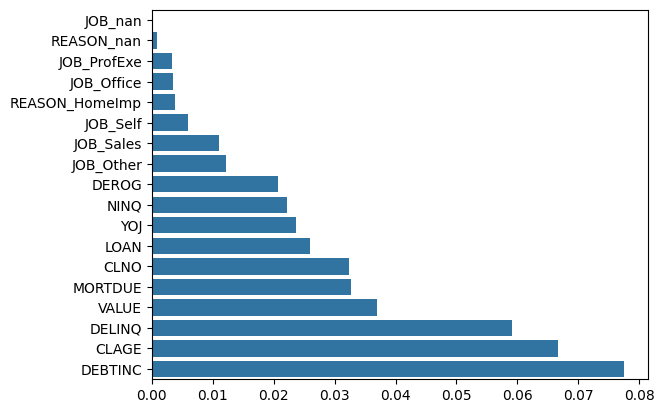

In [19]:
# Sort features in descending order
sort_idx = perm_imp.importances_mean.argsort()

# Bar-plot of RF feature importance 
sns.barplot(x=perm_imp.importances_mean[sort_idx], y=X.columns.values[sort_idx])
plt.show()

Observing the feature DEBTINC to be most important agrees with domain knowledge. A combination of high debt and low income does not really raise trust in a candidate borrower. Our analysis confirms that in this data set, DEBTINC is a feature that has helped the RF to predict the target. Specifically, a value of roughly 0.08 suggests that this feature contributes about 0.08 points to the RF's AUC. Put differently, we would expect AUC to decrease by about 0.08 if the feature is not available. You should now feel highly motivated to train a second RF without DEBTINC and check our interpretation. 

Beyond identifying important features, the plot is also useful to inform feature selection. Do we really need to consider features that contribute less than 0.01 to AUC? A fair question to ask.

Before moving on to other forms of xAI. Let's briefly discuss another - nicer - way to visualize the results of permutation-based feature importance analysis. Specifically, we can exploit the fact that the function `permutation_importance` repeats the calculation by default. We highlight this behavior in the above call by explicitly incorporating the parameter `n_repeats`. Repetition implies that we have multiple (i.e., five) importance scores per feature. Therefore, we can use a box-plot to show the results.

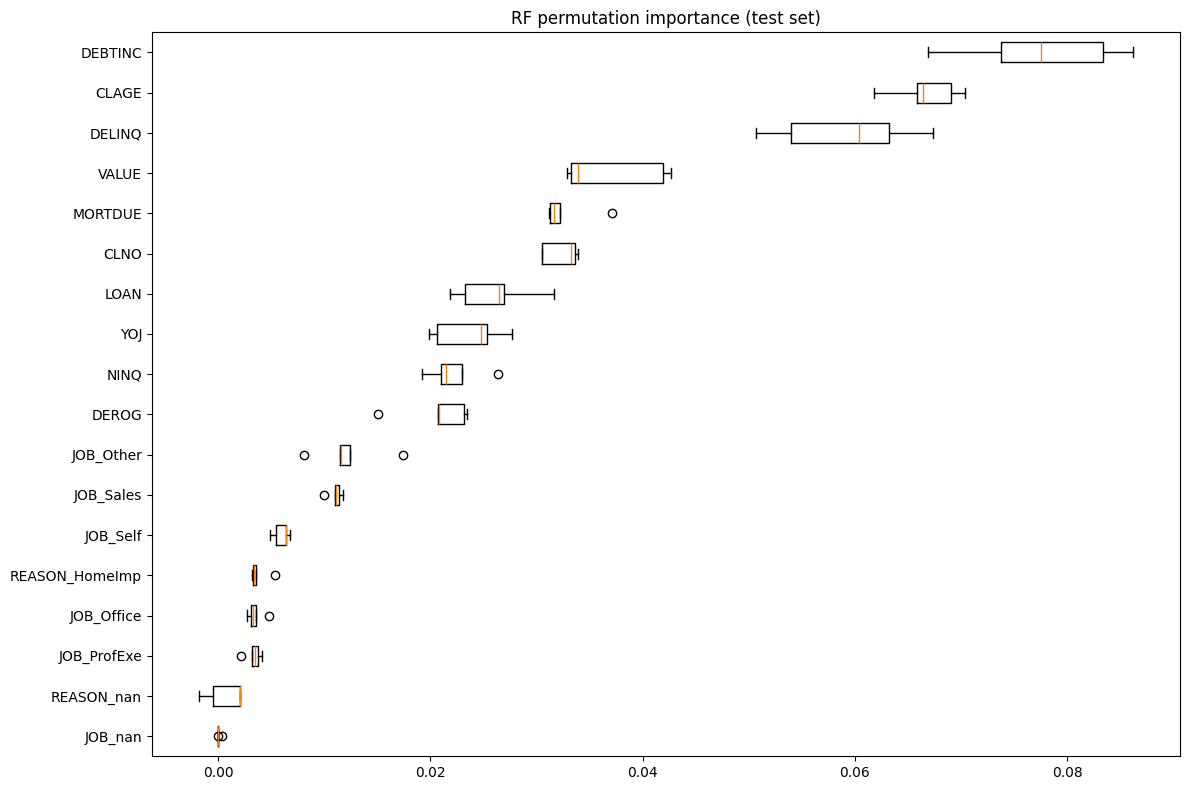

In [25]:
# Box plot of RF feature importance
fig, ax = plt.subplots(figsize=(12,8))
ax.boxplot(perm_imp.importances[sorted_idx].T,
           vert=False, labels=X.columns.values[sorted_idx])
ax.set_title('RF permutation importance (test set)')
fig.tight_layout()
plt.show()

Given the above discussion of the results of impurity-based importance, the use of the previous plot is obvious. The box-plots clearly add additional insight on the robustness of feature importance scores and, more importantly, permutation-based feature importance overcomes the problems - you could say flaws - of impurity-based importance associated with high-cardinal categorical features as discussed above. In summary, to get insight into the global importance of features you want to use permutation-based importance. This is possible with any type of learning algorithm, including but not limited to tree-based classifiers. Different modeling problems such as regression and classification are also supported because the approach is based on a decrease of predictive performance and, therefore, generic. 

To better understand the values of the feature importance scores, you can check out the [`sklearn` documentation where the calculation is detailed](https://scikit-learn.org/stable/modules/permutation_importance.html).  

## Partial dependence analysis
A partial dependence plot (PDP) depicts the **marginal** effect of a feature on model predictions, and this complements permutation-based feature importance analysis. Remember that the latter is useful to understand on which features a model relies. Afterward, however, we still do not know whether higher/lower values of a feature lead to higher/lower predictions. For example, does the model-estimated default probability increase or decrease when the debt-to-income ratio increases? A PDP answers this question and is, therefore, a natural complement to permutation-based feature importance. A PDP plots the values of a focal feature (on the x-axis) against model predictions (on the y-axis) whilst accounting for the combined effect of all other features (hence marginal effect). As discussed in the lecture, this marginalization is basically achieved by examining the model prediction for each value of the focal variable while averaging the values for other variables. We refer to the lecture on interpretable machine learning for a more formal coverage of partial-dependence analysis. Here, we proceed with a demo and examine the partial dependency between the model-estimated probability of default and the feature CLAGE (the age of the oldest credit line in a month).

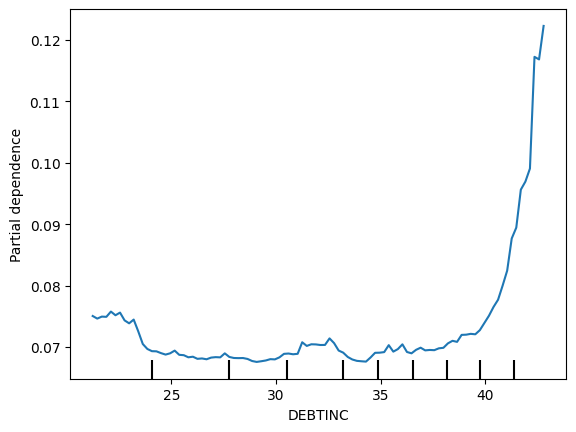

In [31]:
# Partial dependence of DEBTINC
from sklearn.inspection import PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(rf, X_train, features=['DEBTINC'])
plt.show()

**How to read this plot:** <br>
This plot depicts:
- the  selected feature on the x-axis
- the partial dependence/ effect of the selected feature on the outcome
- the deciles of distribution of the focal feature (bars on the x-axis)

The PDP clearly augments our understanding of how the RF classifier uses the information on DEBTINC when calculating predictions. First, the PDP confirms that the predicted probability of default increases with DEBTINC. This is what domain knowledge suggests. However, it is still important to confirm our classifier agrees with domain knowledge. For example, any other result than the above would cast doubt on the classifier and could, therefore, trigger further investigation. 

Second, we find that DEBTINC does, according to the RF, not increase default probability predictions per se. Many values of DEBTINC lead to similar predictions between seven to eight percent. As soon as DEBTINC reaches a value of ~40, however, the predicted default probabilities increase sharply. Keep in mind that this holds for the **predictions** of the RF. The PDP alone cannot prove whether this is a real pattern. The PDP only shows how RF predictions change with a feature. Still, it is useful to know about this behavior. We could now perform further tests to check our actually observed default rates vary with DEBTINC and whether such nonlinear patterns can be detected. Also, recall how the use of DEBTINC feature values in the RF classifier, as revealed by the PDP, differs substantially from how a logistic regression model could use the same information. It would estimate a linear dependency because this is all a logistic regression model can do. 

A risk with PDP analysis is **extrapolation**. The model has estimated the feature-to-target relationship based on the training data. Intuitively, the reliability of this estimate should be good in regions of the feature distributions where there was a lot of training data. Likewise, feature values that only appeared sparsely in the training data, such as very small or large values, may not have allowed reliable estimation of the feature-to-target relationship. This is why the PDP shows the deciles of the feature distribution on the x-axis. In case you wondered, these are the little bars on the x-axis, which are sometimes called rugs. They indicate the first to ninth decile of the feature distribution. Interpreting the PDP outside these regions is dangerous. If needed, you can adjust the percentiles that the function is considering by setting the parameter `percentiles` in the call of the function. 

Finally, in terms of functionality, `sklearn` has certainly a lot more to offer then creating a univariate PDP. The official [function description](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.plot_partial_dependence.html) and [sklearn documentation](https://scikit-learn.org/stable/modules/partial_dependence.html#partial-dependence) offer a lot of additional insight and examples. To transit into the next section on local interpretability, let's sketch one such example, an extension of the PDP to display not the model behavior as a whole but the development of predictions for every individual data point, i.e., every single borrower in our credit risk prediction context. This extension is known as the ICE plot, and is also supported by `PartialDependenceDisplay` by setting the argument `kind` to `individual` as follows.

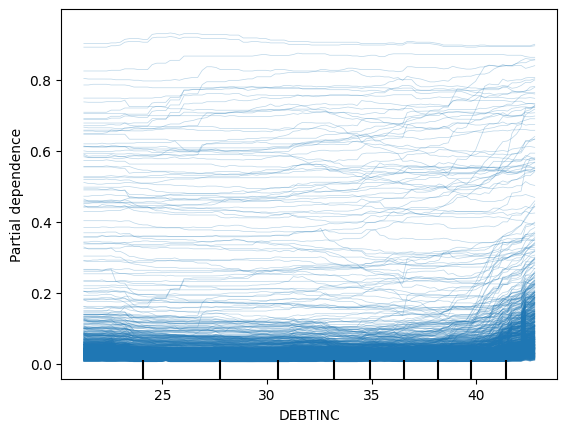

In [33]:
PartialDependenceDisplay.from_estimator(rf, X_train, 
                                        features=['DEBTINC'], 
                                        feature_names=X.columns.values, 
                                        kind='individual');

Comparing the PDP and ICE for the feature DEBTINC is useful to understand the differences between the two plots and get a deeper understanding of how the classifier uses the feature. For example, we can see that the overall trend, which the PDP shows is clearly visible in the ICE. This was to be expected. The additional insight from the ICE concerns the fact that several data points (shown as individual lines in the ICE plot) deviate from the norm. This hints at some interactions of the DEBTINC feature with other features. For example, interactions could explain why the predicted probability to default can be as high as 80 percent or more even if DEBTINC is low. However, another way to interpret the plot is that the beneficial effect of a low DEBTINC may be overruled by other feature values, which lead to high default predictions. Interpreting an opaque classifier is not trivial. The ICE plot is only one piece of the puzzle. Thus, we cannot find out which of the two interpretations is more plausible based on the ICE plot of one variable alone. 

## Local Interpretability 
Techniques discussed up until here aim at interpreting a model at large. Therefore, they belong to the family of global interpretation methods. The lecture also introduced local interpretability and the SHAP framework. The following parts demonstrate this approach. 

Before moving on, please make sure to have the library installed on your machine. If needed, you could install it now using 
```bash
!pip install shap
```

### Shapley Additive Explanations

SHAP (SHapley Additive exPlanations) is a local, model-agnostic explanation method. The concept of the fair payout in a coalition, that is, the Shapley value, was introduced in the scope of cooperative game theory. The Shapley value captures the contribution a player makes to the outcome. <br> *When is this useful?* For example, if a football team wins a game that includes a cash price and wants to distribute this between the players based on their contribution to the result. <br> *How can we use this technique for model explanation?* In a machine learning context, our players are the features and the outcome is the prediction. So, we want to calculate the contribution of each feature to the prediction. <br>  *How is this achieved?* In a nutshell, this is done by changing the data slightly, and observing how the output changes, and then estimating how high each feature's contribution is to the prediction. Using SHAP values for interpretable machine learning was popularized by [Lundberg & Lee (2017)](https://papers.nips.cc/paper/2017/hash/8a20a8621978632d76c43dfd28b67767-Abstract.html).

For this part of the demo notebook, we will use the [SHAP package](https://github.com/slundberg/shap) to apply this method. If you are interested in learning how to write this function from scratch, please follow [this link](
https://afiodorov.github.io/2019/05/20/shap-values-explained/) for a detailed explanation, or ask ChatGPT ;)

#### Calculate SHAP values
To calculate SHAP values, we make use of the `shap.TreeExplainer`, which receives a prediction model (e.g., fitted sklearn model object) as input. More specifically, as the name states, this explainer accepts tree models as input and explains their prediction. It turns out that the computation of SHAP values is very costly. To cope with computational challenges, tailor-made ways to approximate the Shapley value for specific types of prediction models are needed. The `SHAP` library includes solutions for trees, neural networks, and a model agnostic approach, which is much slower than the other two (kindly refer to the [GitHub repositroy](https://github.com/slundberg/shap) for details). Having obtained an explainer object via `object = shap.TreeExplainer(model)`, we get the feature contributions by calling the `shap_values()` function, which receives as an argument the focal data sample `X_test`. 

Whilst SHAP is a local explanation method, this package also facilitates calculating SHAP values for all observations and, as you will see shortly, provides graphical summaries of the entire SHAP values distribution to allow for global interpretation. 

In [56]:
# Import shap 
import shap

# Explainer algorithm  for tree models
explainer = shap.Explainer(rf)

# Calculate SHAP values for all observations

# **** Note that this computation is costly and may take a while to run ****
shap_values = explainer(X_test)
print("Shape of result: {}".format(np.shape(shap_values)))  # some output to signal when done

The shape of the RF model is: (1055, 18, 2)


The dimensionality of the `shap_values` variable is informative. The 1055x18 part makes sense. 1055 is the number of observations in the test set and 18 is the number of features in our data set, for each of which we aim to calculate a SHAP value.

In [38]:
X_test.shape

(1055, 18)

But why have all of this twice?

The answer lies in the way RF produces predictions. From [practical 3](https://github.com/stefanlessmann/ESMT_IML/blob/main/notebooks/p3_classification_solution.ipynb), you will recall that classification models can produce two forms of predictions, discrete class predictions (using `.predict()`) and probability predictions (using `.predict_proba()`). In the latter case, the output is a 2D array comprising the estimated probabilities for class 0 (i.e., good risk) and class 1 (i.e., bad risk). The same concept applies to the SHAP values. We receive them twice because our model predicts two classes. We can subset the array with the index 1, which gives us the  SHAP values for the probability predictions corresponding to class 1 (`shap_values_rf[1]`). This way, we focus on the prediction of the class default=1 or, differently put, bad payers. 

In [ ]:
# Delete shap_values corresponding to class 0 predictions (redundant)
shap_values = shap_values[:,:,1]
shap_values.shape

### SHAP plots
The Shap framework provides a ton of visualizations to diagnose ML models. Some target local interpretability. Others aggregate the individual-level SHAP values to facilitate global interpretability. Below, we will consider some typical use cases and illustrate the way in which they are supported by SHAP. 


We start with the *waterfall* plot. It belongs to the functions targeting local interpretability. Therefore, we first choose a specific observation for inspection. Feel free to change the corresponding variable `test_point` to explore a different observation. You might want to take a look at the observation with index 852.

In [63]:
# Chose row/ observation and extract values
test_point = 2

#### Waterfall plot

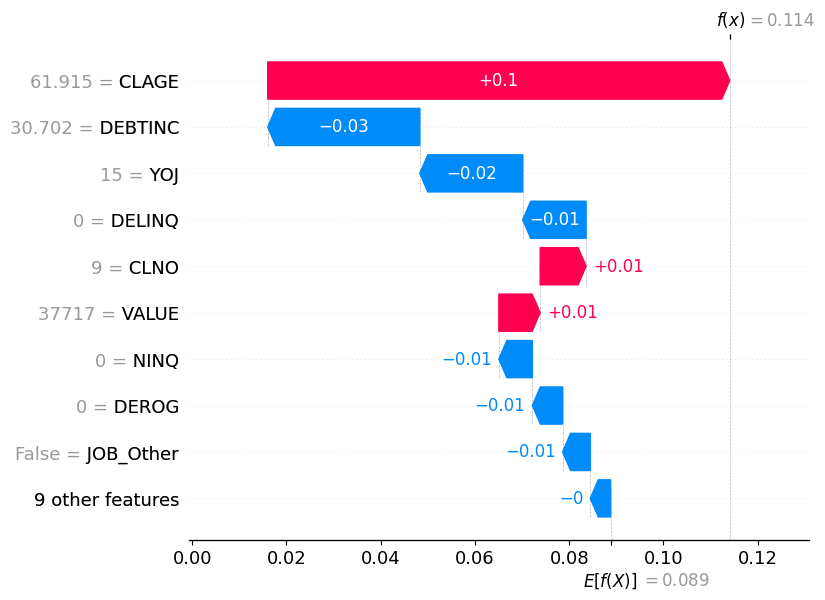

In [69]:
# Local explanation SHAP plot for RF model
shap.initjs()
shap.plots.waterfall(shap_values[test_point])

**How to read this plot:** <br>
This plot depicts:
- the expected value of the model ($E[f(X)]$). Think of it as the average prediction of the model.
- the model prediction (f(x)) for the focal data point
- feature names and their values (note that less important features may get filtered if needed)
- the feature's contribution to the prediction: size and color of arrow, blue for negative impact, red for positive. The size defines how big that feature's impact is. These numbers are the SHAP values.
<br>

Considering the results for `test_point=2`, the RF model predicts the default probability of this client to be 0.114. This prediction is slightly higher than the base rate in the data, which is 0.089. Consequently, the default risk of borrower 2 is predicted to be above average. Why? The reason lies in the client's characteristics (i.e., feature values). For example, the feature CLAGE shows a value of 61.915, which, according to our classifier is a red flag. This feature value increases the estimated default probability by 0.1, as shown by the corresponding SHAP value. On the other hand, the fact that the borrower shows a DEBTINC feature value of 30.702 is a positive signal. This feature value decreases the RF-estimated default probability by 0.03. 

Going through all the other shown features, we can trace how, starting from the base rate, the RF prediction of the specific borrower came into existence. Adding up all the SHAP values amounts to the difference between the model prediction and the base rate. An alternative visualization serving the same purpose is the *force plot*



#### Force plot

In [70]:
shap.initjs()
shap.plots.force(shap_values[test_point])

Which plot to use for local interpretations is a matter of taste. However, a nice feature of the force plot is that it can serve as a starting point to move from local to global interpretability. Taking many force plot explanations such as the one shown above, rotating them by 90 degrees, and then stacking them horizontally, we can see explanations for an entire dataset.

In [71]:
# RF full plot
shap.initjs()
shap.plots.force(shap_values[:100])  # first 100 data points

#### SHAP plots for global interpretability
The SHAP library also featuers plots that mimic the approach taken by the global explanation methods discussed in the previous section. For example, to shed light on global feature importance, we can plot the SHAP values of every feature for every data point. The plot, called `beeswarm` plot, sorts features by the sum of SHAP value magnitudes over all data points, which gives a measure of a feature's overall influence on predictions. The color represents the feature value (red high, blue low). This reveals for example that higher values of DEBTINC increase predicted default risk. 

If you find this output confusing, you can simplify the plot by taking the man absolute value of the SHAP values for each feature, which yields an ordinary bar plot; exactly as in the case of permutation-based feature importance.  

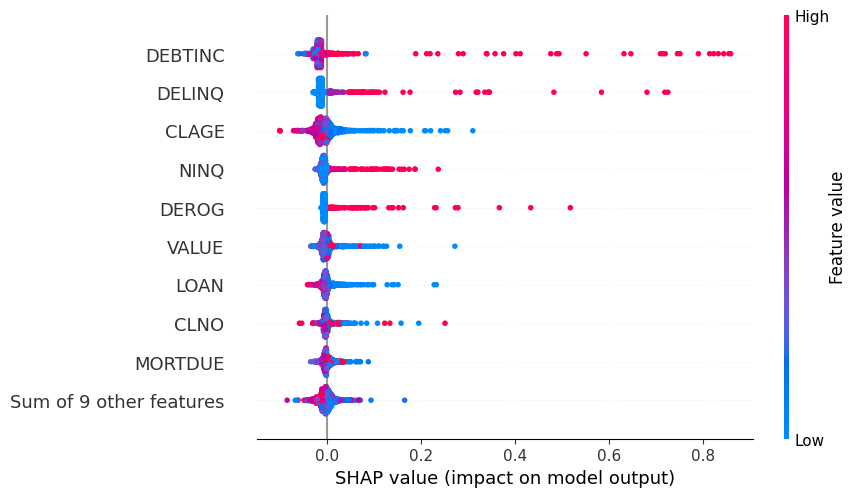

In [72]:
# SHAP-based feature importance analysis 
shap.initjs()
shap.plots.beeswarm(shap_values)

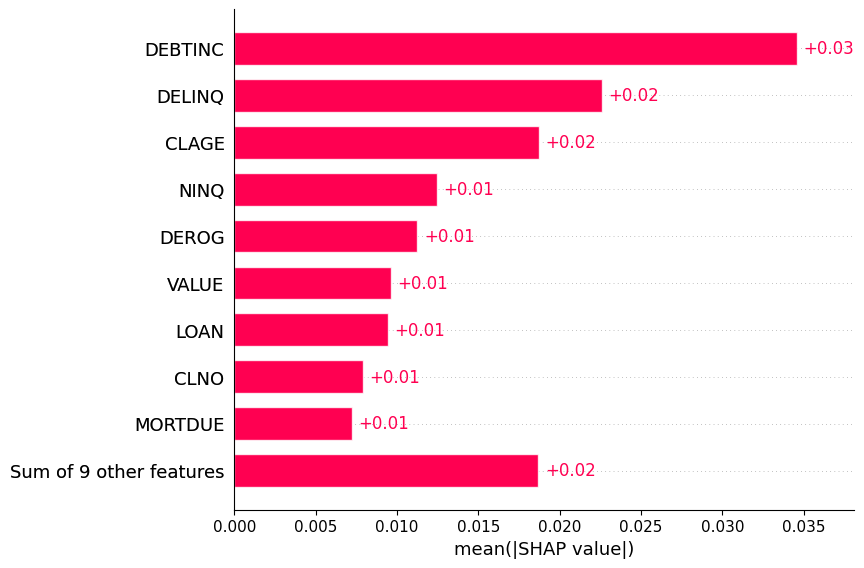

In [74]:
# SHAP-based feature importance analysis simplified
shap.initjs()
shap.plots.bar(shap_values)

In a similar way, SHAP can also mimic the analysis of partial dependence and shed light on a feature's effects on model predictions. To that end, we plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. By design, SHAP values embody the possible *coalitions* (i.e.,feature subsets) to which a feature can contribute information. In this regard, the marginalization of other features' effect, which is instrumental to PDP analysis, has already been taken into account when computing the SHAP values. Hence, SHAP values already represent a feature's responsibility for a change in model predictions and we can simply plot feature values against SHAP values (instead of predictions as in the case of the PDP). We showcase this approach for DEBTINC below.

Vertical dispersion at a single value of DEBTINC represents interaction effects with other features. To help reveal these interactions we can color by another feature. If we pass the whole explanation tensor to the color argument the scatter plot will pick the best feature to color by. In this case it picks NINQ.

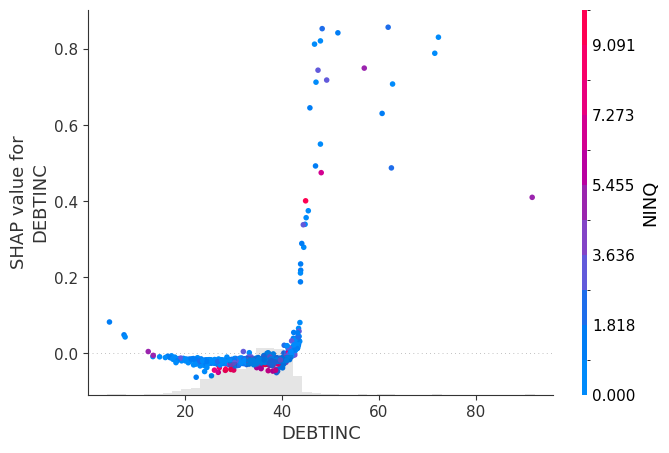

In [73]:
# SHAP-based dependence analysis 
shap.initjs()
shap.plots.scatter(shap_values[:, "DEBTINC"], color=shap_values)

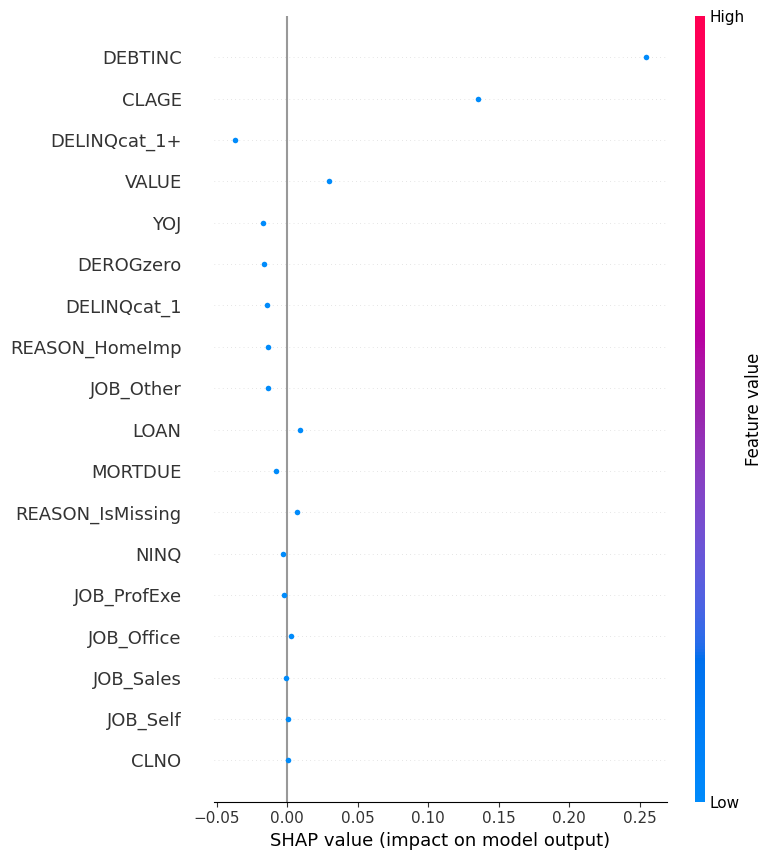

In [90]:
# Summary plot for single observation, RF model
shap.summary_plot(shap_values_rf[test_point][1].reshape(1, -1), X_test.values[test_point].reshape(1, -1), feature_names=X_var_labels)

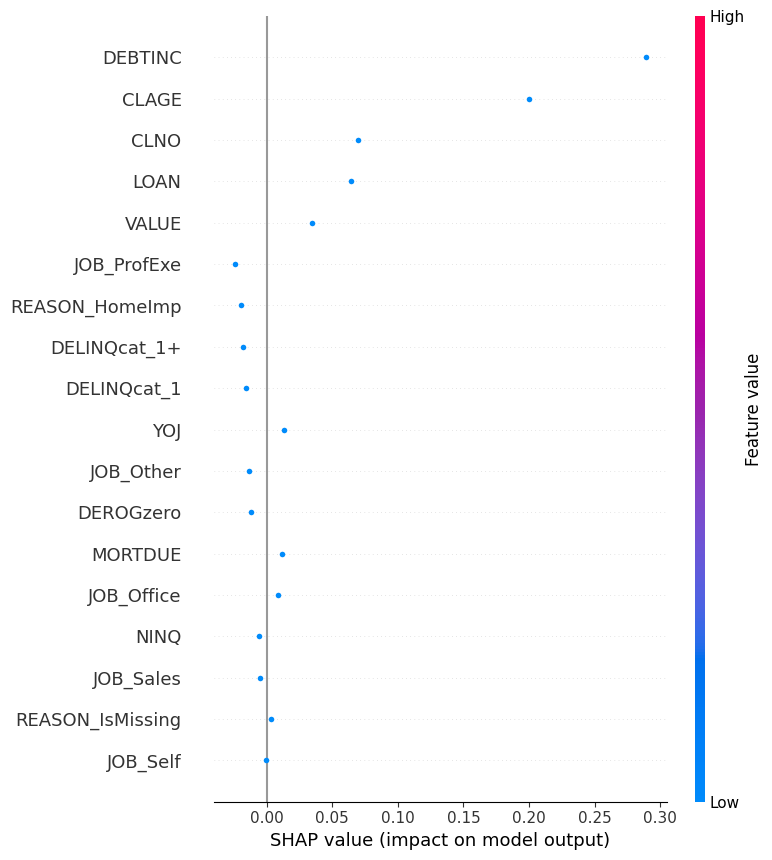

In [91]:
# Repeat for XGB
shap.summary_plot(shap_values_xgb[test_point].reshape(1, -1), X_test.values[test_point].reshape(1, -1), feature_names=X_var_labels)

**How to read this plot:** <br>
This plot depicts:
- features  are ranked in descending order of their impact
- each feature on the y-axis
- a scale of the SHAP values on the x-axis
- the corresponding SHAP value for each feature on the graph
- each point in the plot is color-coded on a scale from blue (low) to red (high) depending on whether or not the value in our data set for this observation and feature was high or low. For a single observation, they tend to all be blue, as there is no comparison as to what is high or low. The next plots will make use of this.

The closer a point is to the horizontal line, the less impact it had on the model output.

*For example*, the feature DEBTINC has a high SHAP value, around +0.25 for the RF model and  XGB model.

**When to use this plot:** <br>
We would use this plot in the same setting as above. It gives us more insight into the SHAP values and just a different type of visualization. We can get a better idea of the actual SHAP values. This plot might be more suitable for a data analyst or someone who often deals with data visualization, while the prior one is explicitly easy to understand for people without much knowledge in this field. This plot's very useful benefit is the ranking of all variables based on their absolute SHAP values. Values that were not visible due to low impact in the first local SHAP plot are displayed here. Generally, this plot makes comparing models easier. We can see that both CLAGE and DEBTINC have similarly high impacts for both models.
On the other hand, the occupation JOB_ProfExe is deemed important for this observation based on the XGB model. In the RF model, however, it shows a SHAP value close to zero. This is an interesting insight and can help decide which model might agree more with domain knowledge. From the previous local plot we can see that the feature value for this feature and observation was 1, so `True`. It seems plausible that a person with this occupation is more likely to pay back their loan as they have a secure job. This finding also reveals a disadvantage of this plot.  We cannot read the feature values of the observation. To see how and how much each variable impacts the output, we will look at the global summary plot. 


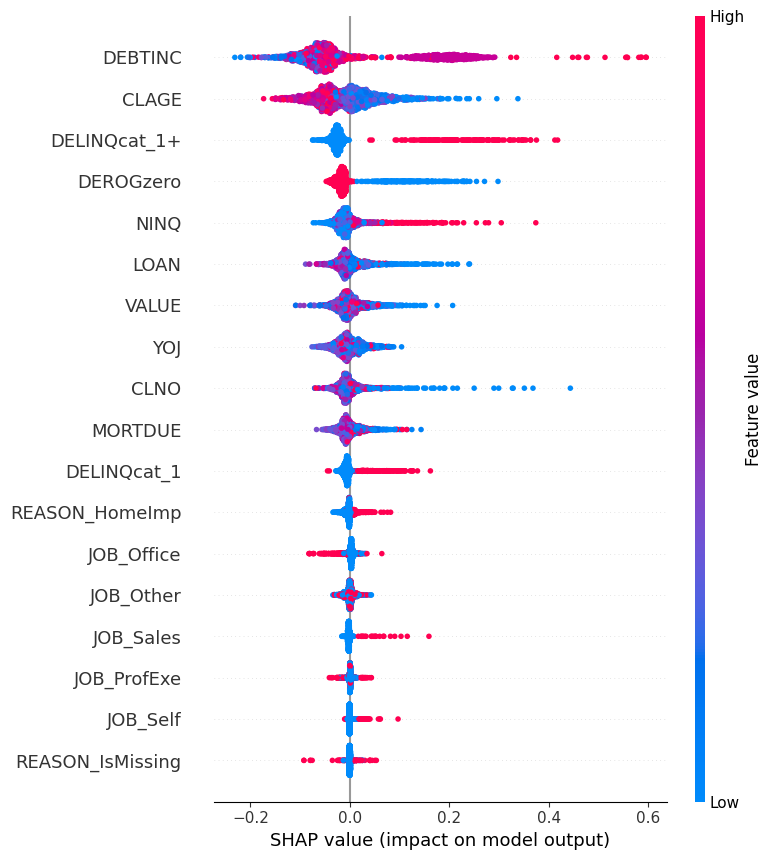

In [92]:
# Summary plot for whole RF not single obsrvation
shap.summary_plot(shap_values_rf[1], X_test, feature_names=X_var_labels)

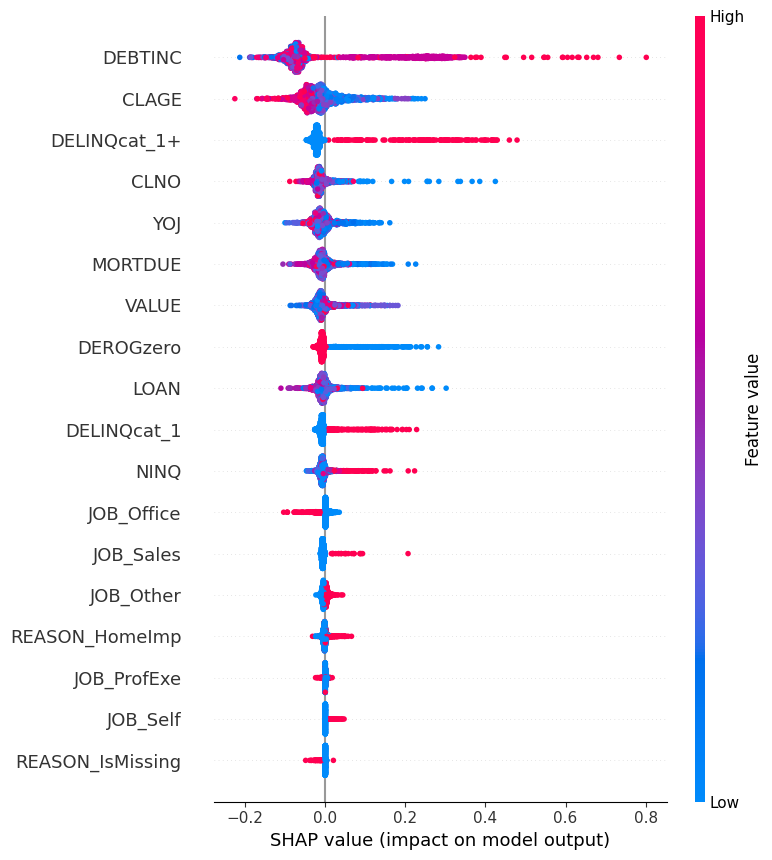

In [93]:
# for whole XGB not single observation
shap.summary_plot(shap_values_xgb, X_test, feature_names=X_var_labels)